# Code to fit one spike and slab distribution to another with variational inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from multiple_subject_vae_2 import BernoulliCondDistribution
from multiple_subject_vae_2 import CondGaussianDistribution
from multiple_subject_vae_2 import CondSpikeSlabDistribution
from multiple_subject_vae_2 import ConstantRealFcn
from multiple_subject_vae_2 import ConstantLowerBoundedFcn
from multiple_subject_vae_2 import LogBumpFcn
from multiple_subject_vae_2 import visualize_spike_slab_distribution

## Generate neuron properties for all of the simulations below

In [3]:
# Properties of neurons we condition on 
n_neurons = 2000
neuron_props = torch.zeros(n_neurons, 2).uniform_()

## Create true spike and slab distribution 

This is the p distribtion in KL(q,p)

In [4]:
p_slab_mn_f = ConstantRealFcn(1)
p_slab_std_f = ConstantLowerBoundedFcn(1)
p_slab_d = CondGaussianDistribution(mn_fcn=p_slab_mn_f, std_fcn=p_slab_std_f)

p_log_prob_fcn = LogBumpFcn(2)
p_log_prob_fcn.log_gain_vl.v.data = torch.tensor([10.0])
p_log_prob_fcn.ctr.data = torch.tensor([.25, .25])
p_log_prob_fcn.ctr_stds.v.data = torch.tensor([-3.0, -3.0])
p_spike_d = BernoulliCondDistribution(p_log_prob_fcn)

p = CondSpikeSlabDistribution(spike_dist=p_spike_d, slab_dist=p_slab_d, d=1)

## Initialize the inference distribution 

In [5]:
q_slab_mn_f = ConstantRealFcn(1)
q_slab_std_f = ConstantLowerBoundedFcn(1)
q_slab_d = CondGaussianDistribution(mn_fcn=q_slab_mn_f, std_fcn=q_slab_std_f)

q_log_prob_fcn = LogBumpFcn(2)
q_log_prob_fcn.log_gain_vl.v.data = torch.tensor([10.0])
q_log_prob_fcn.ctr_stds.v.data = torch.tensor([-2.0, -2.0])
q_spike_d = BernoulliCondDistribution(q_log_prob_fcn)

q = CondSpikeSlabDistribution(spike_dist=q_spike_d, slab_dist=q_slab_d, d=1)

## Fit q to p 

In [6]:
q_slab_params = list(q.slab_dist.parameters())
slab_optimizer = torch.optim.Adam(q_slab_params, lr=.01)

q_spike_params = list(q.spike_dist.parameters())
spike_optimizer = torch.optim.Adam(q_spike_params, lr=.01)

enforce_borders = True
border_bounds = [.05, .95]

#c_net = torch.nn.Sequential(torch.nn.Linear(2, 2), torch.nn.ReLU(), 
#                            torch.nn.Linear(2, 10), torch.nn.ReLU(), 
#                            torch.nn.Linear(10, 10), torch.nn.ReLU(), 
#                            torch.nn.Linear(10, 10), torch.nn.ReLU(),
#                            torch.nn.Linear(10,1))

#c_optimzer = torch.optim.Adam(c_net.parameters(), lr=.01)

n_its = 1000
update_int = 100

for i in range(n_its):
    
    # Sample q
    smp_nz_i, smp_nz_v = q.sample(neuron_props)
    
    y_i = torch.zeros([n_neurons, 1])
    y_i[smp_nz_i, 0] = smp_nz_v
    
    
    # ========================================================================
    # Start by calculating the gradients for the slab parameters
    
    # Temporarily set requires_grad to false for the spike parameters
    for pr in q_spike_params:
        pr.requires_grad = False
    
    # Calculate kl divergence for each sample
    q_ll = q.log_prob(neuron_props, y_i) 
    p_ll = p.log_prob(neuron_props, y_i)
    
    kl = q_ll - p_ll 
    
    # Calculate gradients for the slab parameters
    kl_sum = torch.sum(kl)
    slab_optimizer.zero_grad()
    kl_sum.backward(retain_graph=True)
    
    # Set requires grad back to true for the spike parameters
    for pr in q_spike_params:
        pr.requires_grad = True
        
    # ========================================================================
    # Calculate gradients for the spike parameters 
    
    # Temporarily set requries_grad to false for the slab parameters - this keeps
    # us from updating their gradients when we calculate gradients for the spike
    for pr in q_slab_params:
        pr.requires_grad = False
     
    # Update the spike parameters
    with torch.no_grad():
        learning_sig = kl # Can add in baselines here later
    spike_optimizer.zero_grad()
    spike_o = torch.sum(learning_sig*q.log_prob(neuron_props, y_i))
    spike_o.backward()
    
    # Now we set things up so the slab gradients will be calculated on the next iteration
    for pr in q_slab_params:
        pr.requires_grad = True
    
    # Actually take steps here
    spike_optimizer.step()
    slab_optimizer.step()
    
    if enforce_borders:
        spike_ctr = q.spike_dist.log_prob_fcn.ctr.data.numpy()
        spike_ctr[0] = np.max([np.min([spike_ctr[0], border_bounds[1]]), border_bounds[0]])
        spike_ctr[1] = np.max([np.min([spike_ctr[1], border_bounds[1]]), border_bounds[0]])
        q.spike_dist.log_prob_fcn.ctr.data = torch.from_numpy(spike_ctr)
        
    kl_sum_record = kl_sum.detach().numpy()
    if i % update_int == 0: 
        print('it: ' + str(i) + ', kl_sum: ' + str(kl_sum_record))
    
    
    

it: 0, kl_sum: 8552.061
it: 100, kl_sum: 245.03395
it: 200, kl_sum: 80.74558
it: 300, kl_sum: 43.411015
it: 400, kl_sum: 32.25729
it: 500, kl_sum: 3.2259102
it: 600, kl_sum: 12.125146
it: 700, kl_sum: 9.781256
it: 800, kl_sum: 5.617355
it: 900, kl_sum: 9.475958


## Visualize true and estimated distributions

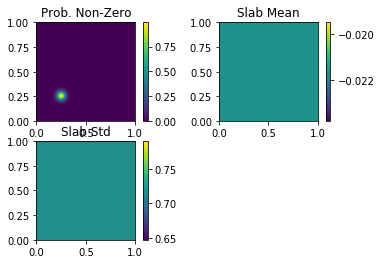

In [7]:
visualize_spike_slab_distribution(p)

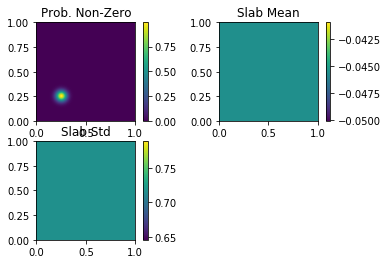

In [8]:
visualize_spike_slab_distribution(q)